In [1]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").config("spark-master", "local").getOrCreate()
spark

### Set up schema and read data from CSV

In [13]:
from pyspark.sql.types import *
struct_fields_list = [
    StructField("age", IntegerType(), True),
    StructField("class_of_worker", StringType(), True),
    StructField("industry_code", StringType(), True),
    StructField("occupation_code", StringType(), True),
    StructField("education", StringType(), True),
    StructField("wage_per_hr", DoubleType(), True),
    StructField("enrolled_in_edu_inst_last_wk", StringType(), True),
    StructField("marital_status", StringType(), True),
    StructField("major_industry_code", StringType(), True),
    StructField("major_occupation_code", StringType(), True),
    StructField("race", StringType(), True),
    StructField("hispanic_origin", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("mem_labour_union", StringType(), True),
    StructField("unemployment_reason", StringType(), True),
    StructField("employment_status", StringType(), True),
    StructField("capital_gain", DoubleType(), True),
    StructField("capital_loss", DoubleType(), True),
    StructField("stock_dividends", DoubleType(), True),
    StructField("tax_filer_status", StringType(), True),
    StructField("prev_region", StringType(), True),
    StructField("prev_state", StringType(), True),
    StructField("household_status", StringType(), True),
    StructField("household_summary", StringType(), True),
    StructField("instance_weight", DoubleType(), True),
    StructField("migration_code_msa", StringType(), True),
    StructField("migration_code_region", StringType(), True),
    StructField("migration_code_within_region", StringType(), True),
    StructField("live_in_this_house_one_year_ago", StringType(), True),
    StructField("migration_prev_res_in_sunbelt", StringType(), True),
    StructField("num_persons_for_employer", IntegerType(), True),
    StructField("parent", StringType(), True),
    StructField("birth_country_father", StringType(), True),
    StructField("birth_country_mother", StringType(), True),
    StructField("birth_country_self", StringType(), True),
    StructField("citizenship", StringType(), True),
    StructField("own_business", StringType(), True),
    StructField("veteran_QA", StringType(), True),
    StructField("veteran_benefits", StringType(), True),
    StructField("weeks_worked_in_yr", IntegerType(), True),
    StructField("year", StringType(), True),
    StructField("income", StringType(), True),
]

schema = StructType(struct_fields_list)

# read data, remove trailing and leading whitespace, set null value to ?
spark_train = spark.read.csv("census-income.data", 
                             schema=schema, 
                             ignoreLeadingWhiteSpace=True,
                             ignoreTrailingWhiteSpace=True,
                             nullValue="?")
spark_test = spark.read.csv("census-income.test", 
                             schema=schema, 
                             ignoreLeadingWhiteSpace=True,
                             ignoreTrailingWhiteSpace=True,
                             nullValue="?")

TRAIN_SIZE = spark_train.count()
TEST_SIZE = spark_test.count()

print("Train set shape: ({},{})".format(TRAIN_SIZE, len(spark_train.columns)))
print("Test set shape: ({}, {})".format(TEST_SIZE, len(spark_test.columns)))

Train set shape: (199523,42)
Test set shape: (99762, 42)


In [14]:
# Get full dataset 
spark_ds = spark_train.union(spark_test)
# Drop instance_weight column (according to dataset description)
spark_ds = spark_ds.drop("instance_weight")
DATASET_SIZE = spark_ds.count()
# Full dataset shape
print("Dataset shape: ({}, {})".format(DATASET_SIZE, len(spark_ds.columns)))
print()
# Print first 5 rows
spark_ds.show(5, truncate=False, vertical=True)

Dataset shape: (299285, 41)

-RECORD 0-------------------------------------------------------------------
 age                             | 73                                       
 class_of_worker                 | Not in universe                          
 industry_code                   | 0                                        
 occupation_code                 | 0                                        
 education                       | High school graduate                     
 wage_per_hr                     | 0.0                                      
 enrolled_in_edu_inst_last_wk    | Not in universe                          
 marital_status                  | Widowed                                  
 major_industry_code             | Not in universe or children              
 major_occupation_code           | Not in universe                          
 race                            | White                                    
 hispanic_origin                 | All other   

In [24]:
target_col = "income"
nominal_cols = [x[0] for x in spark_ds.dtypes if x[1] == "string" and x[0] != target_col]
numeric_cols = [x[0] for x in spark_ds.dtypes if x[1] != "string" and x[0] != target_col]

print("Nominal columns:", nominal_cols)
print("There are {} nominal columns.".format(len(nominal_cols)))
print()
print("Numeric columns:", numeric_cols)
print("There are {} numeric columns.".format(len(numeric_cols)))

Nominal columns: ['class_of_worker', 'industry_code', 'occupation_code', 'education', 'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'mem_labour_union', 'unemployment_reason', 'employment_status', 'tax_filer_status', 'prev_region', 'prev_state', 'household_status', 'household_summary', 'migration_code_msa', 'migration_code_region', 'migration_code_within_region', 'live_in_this_house_one_year_ago', 'migration_prev_res_in_sunbelt', 'parent', 'birth_country_father', 'birth_country_mother', 'birth_country_self', 'citizenship', 'own_business', 'veteran_QA', 'veteran_benefits', 'year']
There are 33 nominal columns.

Numeric columns: ['age', 'wage_per_hr', 'capital_gain', 'capital_loss', 'stock_dividends', 'num_persons_for_employer', 'weeks_worked_in_yr']
There are 7 numeric columns.


### Empty values preprocessing

In [25]:
from pyspark.sql.functions import *

# Count null and empty values in each columns
# In numeric columns
print("Empty values percentage in numeric columns:")
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == ""), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in numeric_cols]).show(vertical=True)
# In nominal columns
print("Empty values percentage in nominal columns:")
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == ""), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in nominal_cols]).show(vertical=True)

Empty values percentage in numeric columns:
-RECORD 0-----------------------
 age                      | 0.0 
 wage_per_hr              | 0.0 
 capital_gain             | 0.0 
 capital_loss             | 0.0 
 stock_dividends          | 0.0 
 num_persons_for_employer | 0.0 
 weeks_worked_in_yr       | 0.0 

Empty values percentage in nominal columns:
-RECORD 0---------------------------------------------
 class_of_worker                 | 0.0                
 industry_code                   | 0.0                
 occupation_code                 | 0.0                
 education                       | 0.0                
 enrolled_in_edu_inst_last_wk    | 0.0                
 marital_status                  | 0.0                
 major_industry_code             | 0.0                
 major_occupation_code           | 0.0                
 race                            | 0.0                
 hispanic_origin                 | 0.0                
 sex                             | 0.0    

In [23]:
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == "") | (col(c) == "Not in universe"), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in nominal_cols]).show(vertical=True)

-RECORD 0---------------------------------------------
 class_of_worker                 | 50.22770937400806  
 industry_code                   | 0.0                
 occupation_code                 | 0.0                
 education                       | 0.0                
 enrolled_in_edu_inst_last_wk    | 93.67893479459379  
 marital_status                  | 0.0                
 major_industry_code             | 0.0                
 major_occupation_code           | 50.44255475550061  
 race                            | 0.0                
 hispanic_origin                 | 0.0                
 sex                             | 0.0                
 mem_labour_union                | 90.46293666571997  
 unemployment_reason             | 96.92600698331022  
 employment_status               | 0.0                
 tax_filer_status                | 0.0                
 prev_region                     | 92.15897889971097  
 prev_state                      | 92.50580550311575  
 household

We can see that all numeric columns do not have empty values. Let's inspect nominal columns which have empty values and process them.

In [26]:
# Inspect columns with empty counts
cols_with_empty_vals = ["prev_state", "migration_code_msa", "migration_code_region", "migration_code_within_region",
                       "migration_prev_res_in_sunbelt", "birth_country_father", "birth_country_mother", "birth_country_self"]

We can see from the output above that 4 columns (which start with migration_code*) have a really high percentage of missing values compared to all other columns (around 50% data missing). We will drop these columns because it might be misleading to include these columns in our classifier.

In [27]:
# Notice that 4 columns: migration_code_* have a really high percentage of null values, ~50%
# Inspect a sample migration_code_* column's unique values count
print("Unique values count of migration_code_msa column:")
spark_ds.groupBy("migration_code_msa")\
        .count()\
        .withColumn("count", col("count") / DATASET_SIZE * 100)\
        .orderBy(desc("count")).show()

# We will drop these columns
redundant_cols = ["migration_code_msa", "migration_code_region", "migration_code_within_region",
                         "migration_prev_res_in_sunbelt"]

spark_ds = spark_ds.drop(*redundant_cols)
cols_with_empty_vals = [c for c in cols_with_empty_vals if c not in redundant_cols]

print("Total number of columns after dropping:", len(spark_ds.columns))

Unique values count of migration_code_msa column:
+------------------+-------------------+
|migration_code_msa|              count|
+------------------+-------------------+
|              null|  49.99983293516214|
|          Nonmover| 41.411029620595755|
|        MSA to MSA| 5.3093205473044085|
|  NonMSA to nonMSA|  1.388308802646307|
|   Not in universe| 0.7481163439530882|
|     MSA to nonMSA| 0.3855856457891308|
|     NonMSA to MSA| 0.3040580049117062|
|  Not identifiable| 0.2105016957081043|
|     Abroad to MSA|0.20682626927510567|
|  Abroad to nonMSA|0.03642013465425931|
+------------------+-------------------+

Total number of columns after dropping: 37


In [28]:
# helper function to get unique values percentage in each column
def get_unique_values_percentage(col_name):
    return spark_ds.groupBy(col_name)\
                    .count()\
                    .withColumn("count", col("count") / DATASET_SIZE * 100)\
                    .orderBy(desc("count"))

# helper function to get most frequent value from unique value counts list
def get_most_freq_value(unique_counts, col_name):
    return unique_counts\
            .orderBy(desc("count"))\
            .select(col_name)\
            .collect()[0][col_name]

# helper function to replace null values in column with new specified value
def replace_nulls(col_name, new_value):
    return spark_ds.withColumn(col_name, \
         when(col(col_name).isNull(), new_value).otherwise(col(col_name)))

For remaining columns with lower percentage of null values, our strategy is to replace null values with the most frequent value in each corresponding column. 

In [29]:
# Deal wih remaining columns with empty values but smaller percentage
prev_state_count = get_unique_values_percentage("prev_state")

birth_country_father_count = get_unique_values_percentage("birth_country_father")

birth_country_mother_count = get_unique_values_percentage("birth_country_mother")

birth_country_self_count = get_unique_values_percentage("birth_country_self")

print("prev_state column unique values count:")
prev_state_count.show()
print("birth_country_father column unique values count:")
birth_country_father_count.show()
print("birth_country_mother column unique values count:")
birth_country_mother_count.show()
print("birth_country_self column unique values count:")
birth_country_self_count.show()

# We will replace null values with the most frequent value in each column
prev_state_most_freq = get_most_freq_value(prev_state_count, "prev_state")
print("Most frequent value in prev_state column:", prev_state_most_freq)

birth_country_father_most_freq = get_most_freq_value(birth_country_father_count, "birth_country_father")
print("Most frequent value in birth_country_father column:", birth_country_father_most_freq)

birth_country_mother_most_freq = get_most_freq_value(birth_country_mother_count, "birth_country_mother")
print("Most frequent value in birth_country_mother column:", birth_country_mother_most_freq)

birth_country_self_most_freq = get_most_freq_value(birth_country_self_count, "birth_country_self")
print("Most frequent value in birth_country_self column:", birth_country_self_most_freq)

# Replace null values
spark_ds = replace_nulls("prev_state", prev_state_most_freq)
spark_ds = replace_nulls("birth_country_father", birth_country_father_most_freq)
spark_ds = replace_nulls("birth_country_mother", birth_country_mother_most_freq)
spark_ds = replace_nulls("birth_country_self", birth_country_self_most_freq)

print("Verify results:")
# verify results
get_unique_values_percentage("prev_state").show()
get_unique_values_percentage("birth_country_father").show()
get_unique_values_percentage("birth_country_mother").show()
get_unique_values_percentage("birth_country_self").show()
print("Empty values count:")
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == ""), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in cols_with_empty_vals]).show(vertical=True)


prev_state column unique values count:
+---------------+-------------------+
|     prev_state|              count|
+---------------+-------------------+
|Not in universe|  92.15897889971097|
|     California|  0.868068897539135|
|           Utah| 0.5336050921362581|
|        Florida| 0.4340344487695675|
| North Carolina|0.40429690762985115|
|           null| 0.3468266034047814|
|         Abroad| 0.3127453764806121|
|       Oklahoma|0.30806756102043203|
|      Minnesota| 0.2903586882068931|
|        Indiana|0.27732763085353423|
|   North Dakota|0.24224401490218353|
|     New Mexico|0.23088360592746046|
|       Michigan| 0.2138429924653758|
|         Alaska|0.13832968575103996|
|        Arizona| 0.1269692767763169|
|  New Hampshire|0.11961842391031959|
|       Kentucky|0.11961842391031959|
|       Colorado|0.11794777553168385|
|         Oregon|0.11560886780159381|
|        Wyoming| 0.1149406084501395|
+---------------+-------------------+
only showing top 20 rows

birth_country_father co

-RECORD 0-------------------
 prev_state           | 0.0 
 birth_country_father | 0.0 
 birth_country_mother | 0.0 
 birth_country_self   | 0.0 



In [30]:
print("Final dataset shape: ({}, {})".format(DATASET_SIZE, len(spark_ds.columns)))

Final dataset shape: (299285, 37)


### Convert target variable (income) for binary classification problem

In [31]:
# Show percentage of each unique values in our target variable
income_count = get_unique_values_percentage("income")
income_count.show()
# We could see that around 94% of our data belongs to -50000 class (below 50$K dollar income/year)
# This signifies a binary classification problem with imbalanced data
# We will convert major label to be 0 (negative) and minor label to be 1 (positive)
major_label = income_count.orderBy(desc("count"))\
                .select("income")\
                .collect()[0]["income"]
minor_label = income_count.orderBy(desc("count"))\
                .select("income")\
                .collect()[1]["income"]

print("Major label:", major_label)
print("Minor label:", minor_label)

# Convert to numeric
spark_ds = spark_ds.withColumn("income", \
         when(col("income") == minor_label, 1).otherwise(0))
# Convert income column to be numeric type (int)
spark_ds = spark_ds.withColumn("income", col("income").cast("int"))

# verify results
print("Verify results:")
get_unique_values_percentage("income").show()

+--------+-----------------+
|  income|            count|
+--------+-----------------+
|- 50000.|93.79588018109828|
| 50000+.|6.204119818901716|
+--------+-----------------+

Major label: - 50000.
Minor label: 50000+.
Verify results:
+------+-----------------+
|income|            count|
+------+-----------------+
|     0|93.79588018109828|
|     1|6.204119818901716|
+------+-----------------+



## Exploration data analysis

In [32]:
target_col = "income"
nominal_cols = [x[0] for x in spark_ds.dtypes if x[1] == "string" and x[0] != target_col]
numeric_cols = [x[0] for x in spark_ds.dtypes if x[1] != "string" and x[0] != target_col]

print("Nominal columns:", nominal_cols)
print("There are {} nominal columns.".format(len(nominal_cols)))
print()
print("Numeric columns:", numeric_cols)
print("There are {} numeric columns.".format(len(numeric_cols)))

Nominal columns: ['class_of_worker', 'industry_code', 'occupation_code', 'education', 'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'mem_labour_union', 'unemployment_reason', 'employment_status', 'tax_filer_status', 'prev_region', 'prev_state', 'household_status', 'household_summary', 'live_in_this_house_one_year_ago', 'parent', 'birth_country_father', 'birth_country_mother', 'birth_country_self', 'citizenship', 'own_business', 'veteran_QA', 'veteran_benefits', 'year']
There are 29 nominal columns.

Numeric columns: ['age', 'wage_per_hr', 'capital_gain', 'capital_loss', 'stock_dividends', 'num_persons_for_employer', 'weeks_worked_in_yr']
There are 7 numeric columns.


We will explore numeric columns first, then move on to nominal columns. We will also try to only show columns with meaningful data because the total number of columns might be too large.

### Age

#### General statistics

In [33]:
spark_ds.select("age").describe().show()
median_age = spark_ds.approxQuantile("age", [0.5], 0)[0]
print("Median age:", median_age)

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|            299285|
|   mean|34.538997945102494|
| stddev|22.318468266432593|
|    min|                 0|
|    max|                90|
+-------+------------------+

Median age: 33.0


#### Plot
We will plot histogram labeled by target column (i.e. income).

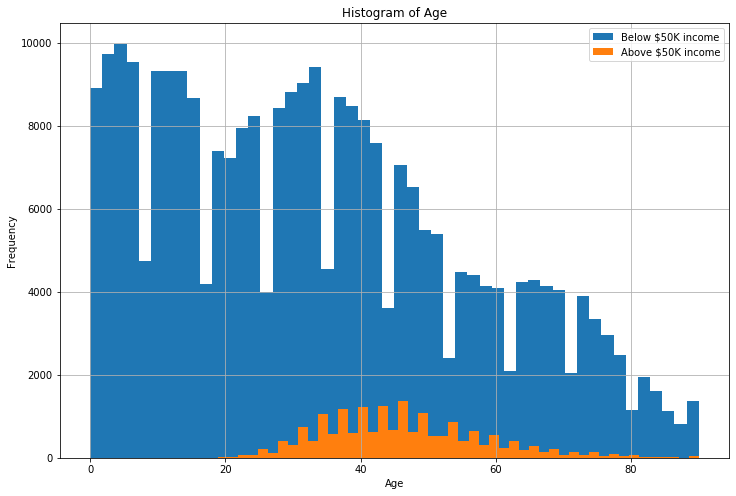

In [34]:
age_0 = spark_ds.where(col("income") == 0).select("age").rdd.flatMap(lambda x: x).collect()
age_1 = spark_ds.where(col("income") == 1).select("age").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.hist(age_0, bins=50, label="Below $50K income")
plt.hist(age_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Age")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

- We can see that people who have above \\$50K income are more than 20 years old (age > 20).
- Most of people who have > \\$50K+ income are from ~30 - ~60 years old.
- The data distribution is slightly right-skewed. You can see that from the point of age 50 onwards, the frequency column's height is almost half.
- More younger people (age < 50) takes part in the survey (census) than older people (age > 50).

### Wage/hr

#### General statistics

In [35]:
# convert to dollars first (original data is in cents unit)
converted_wage_per_hr = spark_ds.select((col("wage_per_hr") / 100).alias("wage_per_hour ($)"))

In [36]:
converted_wage_per_hr.describe().show()
median_wage_per_hr = converted_wage_per_hr.approxQuantile("wage_per_hour ($)", [0.5], 0)[0]
print("Median wage/hr:", median_wage_per_hr)

+-------+------------------+
|summary| wage_per_hour ($)|
+-------+------------------+
|  count|            299285|
|   mean|0.5510502698097132|
| stddev|  2.73340728614754|
|    min|               0.0|
|    max|             99.99|
+-------+------------------+

Median wage/hr: 0.0


#### Plot

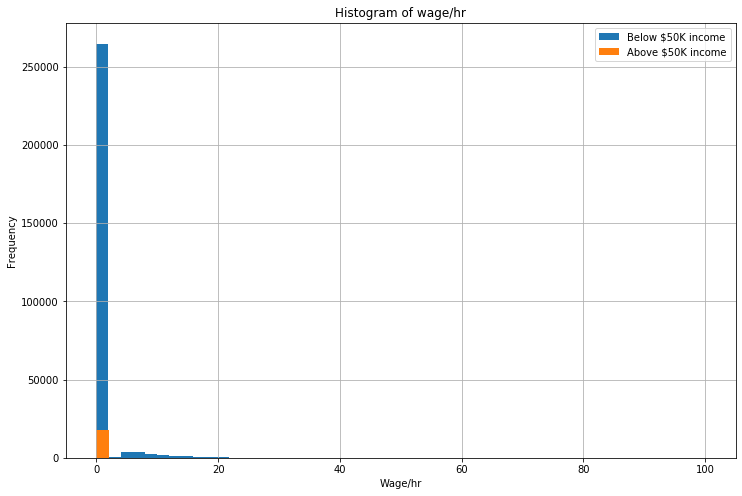

In [37]:
wage_per_hr_0 = spark_ds.where(col("income") == 0).select(col("wage_per_hr") / 100).rdd.flatMap(lambda x: x).collect()
wage_per_hr_1 = spark_ds.where(col("income") == 1).select(col("wage_per_hr") / 100).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.hist(wage_per_hr_0, bins=50, label="Below $50K income")
plt.hist(wage_per_hr_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of wage/hr")
plt.xlabel('Wage/hr')
plt.ylabel('Frequency')
plt.show()

- The data distribution is extremely right skewed. Most of the data's wage per hour is 0, meaning most of the people doing the survey does not have a job. We can also see that most of the people who have low wage/hr (below \\$20/hr) have below \\$50K+ income/yr.
- Interestingly, most of people who have above \$50k+ income (orange part), have wage/hr equals 0. This might mean they have a different source of income other than working or maybe the data might be corrupted.

### Capital loss, capital gain and stock dividends
Like wage/hr column above, these columns also have extremely right-skewed data distribution, i.e. most of the data have value 0.

#### General statistics

In [38]:
spark_ds.select("capital_loss", "capital_gain", "stock_dividends").describe().show()
median_capital_loss = spark_ds.approxQuantile("capital_loss", [0.5], 0)[0]
median_capital_gain = spark_ds.approxQuantile("capital_gain", [0.5], 0)[0]
median_stock_dividends = spark_ds.approxQuantile("stock_dividends", [0.5], 0)[0]
print("Median capital loss:", median_capital_loss)
print("Median capital gain:", median_capital_gain)
print("Median capital stock_dividends:", median_stock_dividends)

+-------+-----------------+------------------+-----------------+
|summary|     capital_loss|      capital_gain|  stock_dividends|
+-------+-----------------+------------------+-----------------+
|  count|           299285|            299285|           299285|
|   mean|36.84901014083566| 431.7421755183187|195.8512588335533|
| stddev|269.7897707879308|4670.7685357730525|1937.847082062182|
|    min|              0.0|               0.0|              0.0|
|    max|           4608.0|           99999.0|          99999.0|
+-------+-----------------+------------------+-----------------+

Median capital loss: 0.0
Median capital gain: 0.0
Median capital stock_dividends: 0.0


#### Plot

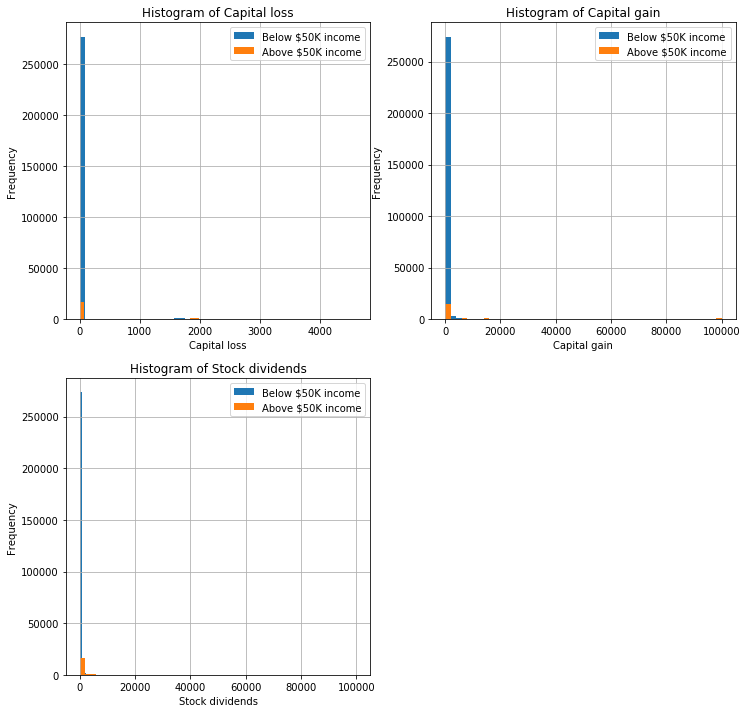

In [39]:
capital_loss_0 = spark_ds.where(col("income") == 0).select("capital_loss").rdd.flatMap(lambda x: x).collect()
capital_loss_1 = spark_ds.where(col("income") == 1).select("capital_loss").rdd.flatMap(lambda x: x).collect()
capital_gain_0 = spark_ds.where(col("income") == 0).select("capital_gain").rdd.flatMap(lambda x: x).collect()
capital_gain_1 = spark_ds.where(col("income") == 1).select("capital_gain").rdd.flatMap(lambda x: x).collect()
stock_0 = spark_ds.where(col("income") == 0).select("stock_dividends").rdd.flatMap(lambda x: x).collect()
stock_1 = spark_ds.where(col("income") == 1).select("stock_dividends").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,12))
# Capital loss histogram
plt.subplot(2,2,1)
plt.hist(capital_loss_0, bins=50, label="Below $50K income")
plt.hist(capital_loss_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Capital loss")
plt.xlabel('Capital loss')
plt.ylabel('Frequency')

# Capital gain histogram
plt.subplot(2,2,2)
plt.hist(capital_gain_0, bins=50, label="Below $50K income")
plt.hist(capital_gain_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Capital gain")
plt.xlabel('Capital gain')
plt.ylabel('Frequency')

# Stock dividends histogram
plt.subplot(2,2,3)
plt.hist(stock_0, bins=50, label="Below $50K income")
plt.hist(stock_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Stock dividends")
plt.xlabel('Stock dividends')
plt.ylabel('Frequency')

plt.show()

### Weeks worked in year

#### General statistics

In [40]:
spark_ds.select("weeks_worked_in_yr").describe().show()
median_weeks_worked_in_yr = spark_ds.approxQuantile("weeks_worked_in_yr", [0.5], 0)[0]
print("Median weeks worked in a year:", median_weeks_worked_in_yr)

+-------+------------------+
|summary|weeks_worked_in_yr|
+-------+------------------+
|  count|            299285|
|   mean| 23.17837512738694|
| stddev| 24.40401555222534|
|    min|                 0|
|    max|                52|
+-------+------------------+

Median weeks worked in a year: 8.0


#### Plot

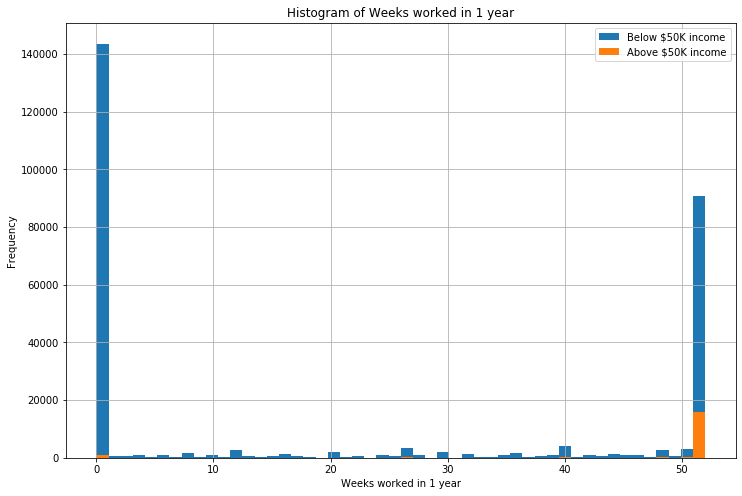

In [41]:
weeks_worked_0 = spark_ds.where(col("income") == 0).select("weeks_worked_in_yr").rdd.flatMap(lambda x: x).collect()
weeks_worked_1 = spark_ds.where(col("income") == 1).select("weeks_worked_in_yr").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.hist(weeks_worked_0, bins=50, label="Below $50K income")
plt.hist(weeks_worked_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Weeks worked in 1 year")
plt.xlabel('Weeks worked in 1 year')
plt.ylabel('Frequency')
plt.show()

- The data distribution is very interesting. Most of the people either do not work (i.e. 0 week) or work for a whole year (i.e. 52 weeks). 
- A smaller number of people works part time during the year (lower frequency bars in the middle of the plot)
- We can clearly see that most of people who have above \$50K+ income/yr works for a whole year (orange part in week 52 bar).

### Scatter plot

#### Age vs Wage/hr

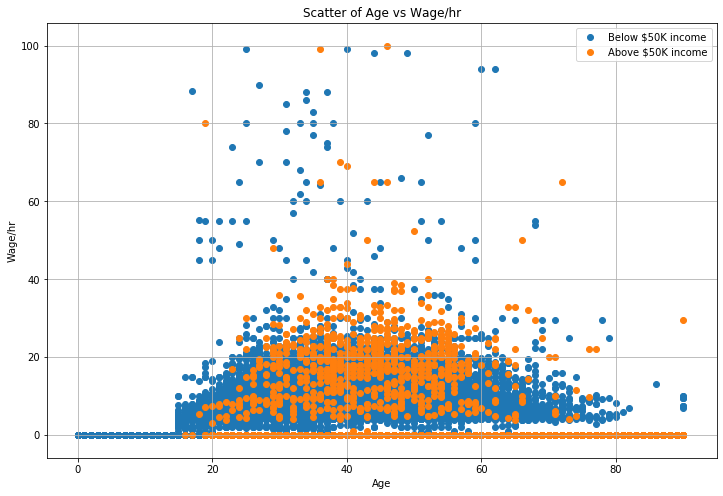

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, wage_per_hr_0, label="Below $50K income")
plt.scatter(age_1, wage_per_hr_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Wage/hr")
plt.xlabel('Age')
plt.ylabel('Wage/hr')
plt.show()

- We can see that most of the people who have above \\$50k+ income have wage/hr < \\$40/hr.
- Above the threshold of \\$40 wage/hr, there are more people (\*) with <50$K+ income than people with >\\$50K+ income. These people (\*) probably worked part time instead of full-time.

####  Age vs Capital gain

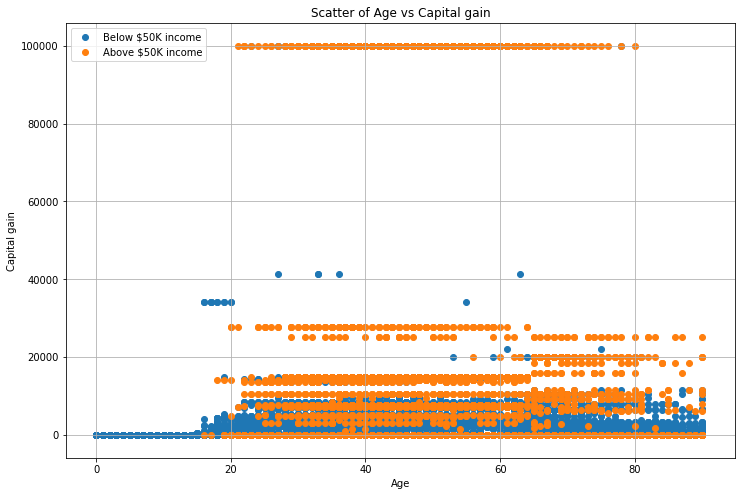

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, capital_gain_0, label="Below $50K income")
plt.scatter(age_1, capital_gain_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Capital gain")
plt.xlabel('Age')
plt.ylabel('Capital gain')
plt.show()

- We can see most of the people have capital gain below \\$40K. Capital gain below \\$40K does not necessarily mean that your income will be lower than \\$50K, but really high capital gain as we can see (around \\$100K) will result in >\\$50K+ income.

#### Age vs Capital loss

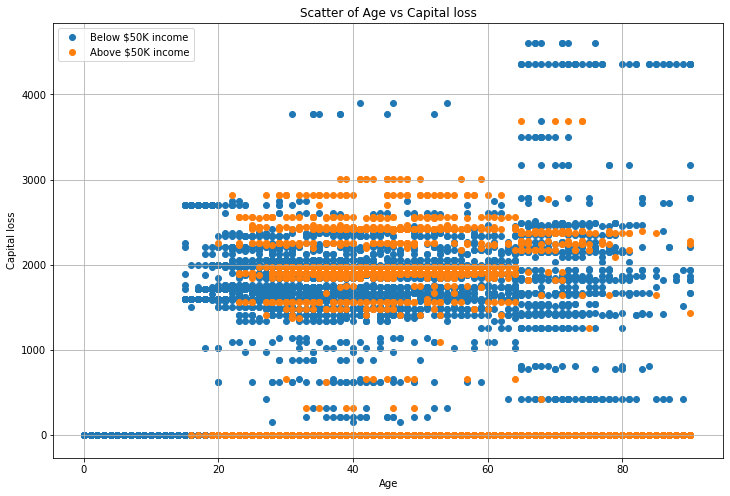

In [44]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, capital_loss_0, label="Below $50K income")
plt.scatter(age_1, capital_loss_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Capital loss")
plt.xlabel('Age')
plt.ylabel('Capital loss')
plt.show()

- We can see that almost all people with above $50K+ income have capital loss lower than \\$3000.
- Intuitively, people who have a high capital loss, i.e. above \\$3K, tend to have below \\$50K+ income.

#### Age vs stock dividends

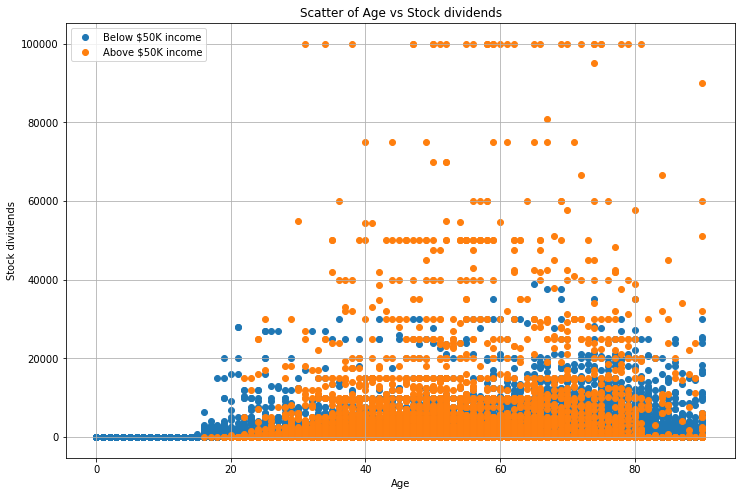

In [45]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, stock_0, label="Below $50K income")
plt.scatter(age_1, stock_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Stock dividends")
plt.xlabel('Age')
plt.ylabel('Stock dividends')
plt.show()

- Below the threshold of \\$40K stock dividends, there are both type of income, either above or below \\$50K.
- Above the threshold of \\$40K stock dividends, there are only people with income above $50K.

### Nominal columns
We will mainly use stacked bar plot labeled by income for nominal columns to visualize our data.

In [ ]:
# cat_train[cat_train.income_encode == 0].class_of_worker.value_counts().plot(kind='bar', label="0", color="blue")
# cat_train[cat_train.income_encode == 1].class_of_worker.value_counts().plot(kind='bar', label="1", color="red")
# plt.legend()
# plt.grid()
# plt.title("Histogram of class of worker")
# plt.xlabel('Class of Worker')
# plt.ylabel('Frequency')

## Pyspark MLlib process

### Data preprocessing pipelines
The preprocessing pipeline will make sure that the features are converted correctly to be put into the ML classifier. This will include:
1. Standardize (z-score) numeric columns
2. For categorical columns:
    2.1. First, use StringIndexer to convert categorical columns to be numeric.
    2.2. Second, use OneHotEncoderEstimator to one hot encode the output of (2.1)
3. Use VectorAssembler to combine all columns we have to a single svector column called "features". This will be the input to our ML classifier later

In [ ]:
# Preprocessing data pipelines: includes 

### Convert to pandas dataframe

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 50)
# Pandas dataframe
pd_dataset = spark_ds.toPandas()
# To get train and test set
pd_train = pd_dataset.iloc[:TRAIN_SIZE, :]
pd_test = pd_dataset.iloc[TRAIN_SIZE:, :]

pd_train.shape
pd_test.shape

In [ ]:
pd_dataset.head()

In [ ]:
# verify that there are no missing values :)
pd_dataset.isnull().sum().sort_values(ascending=False)